# Get GTs crops with 'can' label

In [8]:
import json

# Specify the path to your JSON file
file_path = "/work3/s212725/WasteProject/data/json/corrected_test_region_proposals_3.json"

# Load the JSON file
with open(file_path) as file:
    data = json.load(file)

In [9]:
gts_with_path = []
# Access and work with the loaded data
for path, label in data.items():
    if 'gt' in path:
        if label == 6:
            gts_with_path.append(path)

print(len(gts_with_path))

38


Let's save the gts paths in a file so that we can use them later to run the IoU

In [37]:
import pickle

# Specify the path to your pickle file
file_path = "/work3/s212725/WasteProject/data/json/cans_gt_paths.pickle"

# Save the array to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(gts_with_path, file)


THERE ARE 38 GTs WITH CAN LABEL

In [11]:
import json

# Specify the path to your JSON file
file_path = "/work3/s212725/WasteProject/data/json/corrected_test_region_proposals_3.json"

# Load the JSON file
with open(file_path) as file:
    data = json.load(file)
    
print(len(data))

23224


# Remove the gt crops from the testing dataset

In [5]:
import json

# Specify the path to your JSON file
file_path = "/work3/s212725/WasteProject/data/json/corrected_test_region_proposals_3.json"

# Load the JSON file
with open(file_path) as file:
    data = json.load(file)

# Iterate over the data and remove entries containing 'gt'
updated_data = {path: label for path, label in data.items() if 'gt' not in path}

new_file_path = "/work3/s212725/WasteProject/data/json/new_corrected_test_region_proposals_3.json"
# Write the updated data back to the JSON file
with open(new_file_path, 'w') as file:
    json.dump(updated_data, file)

# Let's do the testing and get the outputs per crop

In [27]:
#!/usr/bin/python
# 

import os
from pathlib2 import Path
import torch.nn.functional as F
import torch
import wandb
import pickle
import time
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from src.data.rp_dataloader import RegionProposalsDatasetTrain, RegionProposalsDataset
from src.data.data_sampler import BalancedSampler
import torchvision.transforms as transforms
from tqdm import trange, tqdm
from src.models.model import get_model
from src.models.utils import set_seed, load_experiment
import json

# Hyperparameters
batch_size = 12

# Set seed
torch.manual_seed(seed=14)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"INFO - using device: {device}")

# ---------------------------- Load Model Checkpoint ---------------------------- #
experiment_checkpoint   = 'ResNet18-lr1e-05.wd0.001.bz32.seed14/best.ckpt'
# Define experiment path
BASE_PATH = Path(r"/work3/s212725/WasteProject")
experiment_path = BASE_PATH / 'models' / experiment_checkpoint

# Load experiment stored from training
model_name, model, criterion = load_experiment(experiment_path, device=device)
model.eval()

#  ---------------  Datasets  ---------------
# define transforms to resize - warping proposals
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

paths_to_probs = {}
path_test = r"/work3/s212725/WasteProject/data/json/new_corrected_test_region_proposals_3.json"
test_dataset = RegionProposalsDataset(path_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# ---------------- Testing loop ---------------- #
with torch.no_grad():
    test_loss = 0
    test_correct = 0
    test_total = 0
    for batch in tqdm(test_loader):
        images, labels, paths = batch
        images, labels = images.to(device), labels.to(device)

        # Forward + backward
        outputs = model(images)
        probs = torch.exp(outputs)
        preds = torch.exp(outputs).topk(1)[1]
        
        for path, prob in zip(paths, probs):
            paths_to_probs[path] = prob.tolist()

        # Compute loss
        batch_loss = criterion(outputs, labels)
        test_loss += batch_loss.item()

        # Compute accuracy
        batch_correct = (preds.squeeze() == labels).sum().item()
        test_correct += batch_correct
        test_total += labels.size(0)

    # Compute average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_correct / test_total

    print('Test loss: {:.4f}'.format(avg_test_loss))
    print('Test accuracy: {:.2%}'.format(avg_test_acc))
    
# Specify the path for the new JSON file
output_file_path = "/work3/s212725/WasteProject/data/json/paths_to_probs.json"

# Write the dictionary to a JSON file
with open(output_file_path, 'w') as file:
    json.dump(paths_to_probs, file)

INFO - using device: cuda:0

INFO - LOADED EXPERIMENT: ResNet18-lr1e-05.wd0.001.bz32.seed14
INFO -  model: {'name': 'ResNet18'}
INFO -  seed: 14
INFO -  best epoch: 1
INFO -  data: 



100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:22<00:00, 84.47it/s]


Test loss: 0.1205
Test accuracy: 97.48%


Let's analyse the output of probs

In [34]:
import json

# Specify the path to your JSON file
file_path = "/work3/s212725/WasteProject/data/json/paths_to_probs.json"

# Load the JSON file
with open(file_path) as file:
    data = json.load(file)
    
for path, prob in data.items():
    print(prob[6])
    break

29
[0.0002820167865138501, 0.00012348090240266174, 0.00022869101667311043, 0.00026242044987156987, 0.0003906650235876441, 0.00030790004529990256, 0.00027280644280835986, 0.0003325119032524526, 0.0002215070417150855, 0.00023304748174268752, 0.0002988692722283304, 0.00025941463536582887, 0.0004322165041230619, 0.00032813448342494667, 0.00033234074362553656, 0.00039599090814590454, 0.0004831827827729285, 0.0002354155294597149, 0.00030198448803275824, 0.0001878525799838826, 0.0003268330474384129, 0.00024096171546261758, 0.00011404857650632039, 0.0005037937080487609, 0.0005702293128706515, 0.00023292815603781492, 0.0002569080679677427, 0.0005454313359223306, 0.991298258304596]
0.00027280644280835986


Let's order the paths based in the order of probs[6]

In [36]:
import json

# Specify the path to the JSON file
input_file_path = "/work3/s212725/WasteProject/data/json/paths_to_probs.json"
output_file_path = "/work3/s212725/WasteProject/data/json/paths_to_probs_ordered.json"

# Load the data from the JSON file
with open(input_file_path) as file:
    data = json.load(file)

# Sort the data based on prob[6] in decreasing order
sorted_data = sorted(data.items(), key=lambda x: x[1][6], reverse=True)

# Create a new ordered dictionary
ordered_data = {}
for path, prob in sorted_data:
    ordered_data[path] = prob

# Write the ordered data to a new JSON file
with open(output_file_path, 'w') as file:
    json.dump(ordered_data, file)


Are there actually any can gts in the new crops?

In [35]:
import json

# Specify the path to your JSON file
file_path = "/work3/s212725/WasteProject/data/json/new_corrected_test_region_proposals_3.json"

# Load the JSON file
with open(file_path) as file:
    data = json.load(file)
    
cans_in_crops = []
# Access and work with the loaded data
for path, label in data.items():
    if label == 6:
        cans_in_crops.append(path)

print(len(cans_in_crops))

44


Yes there are 44

So we have a json file containing the ordered paths in terms of the classification accuracy. I can get the first path, the compute IoU with the GTs, then see if I classify it as positive (if it intersects with the GTs). However, the IoU does not need to be computer because it has already been done and the GT labels are provided in "/work3/s212725/WasteProject/data/json/corrected_test_region_proposals_3.json". So the only thing to do is: 1. Get paths from ordered list. Check the label of that path in corrected_test_region_proposals_3.json. If positive count, if not don´t.

In [41]:
def cans_in_path(data):
    gts_with_path = []
    # Access and work with the loaded data
    for path, label in data.items():
        if 'gt' in path:
            if label == 6:
                gts_with_path.append(path)

    return len(gts_with_path)

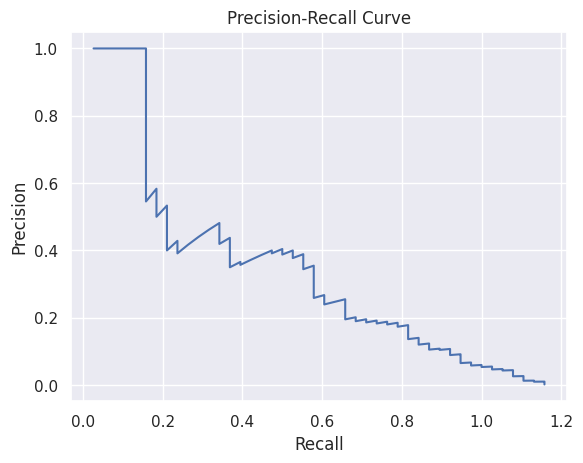

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import json

def detection_matches_ground_truth(path, data_gts):
    for path_gt, label in data_gts.items():
        if path == path_gt:
            if label == 6:
                return True
    return False

def cans_in_path(data):
    gts_with_path = []
    # Access and work with the loaded data
    for path, label in data.items():
        if 'gt' in path:
            if label == 6:
                gts_with_path.append(path)

    return len(gts_with_path)

file_path = "/work3/s212725/WasteProject/data/json/paths_to_probs_ordered.json"
gt_path_labels = "/work3/s212725/WasteProject/data/json/corrected_test_region_proposals_3.json"

# Load the data from the JSON file
with open(gt_path_labels) as file_gts:
    data_gts = json.load(file_gts)
    
# Load the data from the JSON file
with open(file_path) as file:
    data = json.load(file)


# Initialize variables
TP = 0
FP = 0
GT = cans_in_path(data_gts)
precision_values = []
recall_values = []

# Iterate through each detection
for path, prob in data.items():
    if detection_matches_ground_truth(path, data_gts):
        TP += 1
    else:
        FP += 1

    # Calculate precision and recall
    precision = TP / (TP + FP)
    recall = TP / GT

    # Append precision and recall values
    precision_values.append(precision)
    recall_values.append(recall)

# Plot the precision-recall curve
plt.plot(recall_values, precision_values)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Calculate mean precision and mean recall
mean_precision = np.mean(precision_values)
mean_recall = np.mean(recall_values)


In [47]:
print(mean_precision)

0.011180557836848999


In [48]:
# Calculate the area under the curve (AUC)
auc = np.trapz(precision_values, recall_values)

print('Area Under the Curve (AUC): {:.4f}'.format(auc))

Area Under the Curve (AUC): 0.3806
